# Setup Code

In [120]:
# some setup code
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import layers
import params
from config import VERBOSE

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

USE_GPU = True
print(torch.__version__)
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)
print('VERBOSE==',VERBOSE)

img_size = params.img_size
img_channel = params.img_channel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0
using device: cuda
VERBOSE== False


# Data Loading

In [12]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST= 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./datasets/MNIST_data', train=True, download=False,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./datasets/MNIST_data', train=True, download=False,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

mnist_test = dset.MNIST('./datasets/MNIST_data', train=False, download=False,
                           transform=T.ToTensor())
loader_test = DataLoader(mnist_test, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_TEST,0))

imgs = loader_test.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
#show_images(imgs)

# Network Architecture

In [13]:
def Encoder(img_size, in_channel, conv_channel, filter_size, latent_dim, dense_size, bn):
    inner_conv_channel = conv_channel//2
    if img_size%4 != 0:
        print("WARNING: image size mod 4 != 0, may produce bug.")
    # total input number of the input of the last conv layer, new image size = old / 2 / 2 
    flatten_img_size = inner_conv_channel * img_size/4 * img_size/4
    
    # explain: first two layer's padding = 2, because we set W/S = W/S + floor((-F+2P)/S+1), S=2,F=5,so P=2
    if VERBOSE:
        print(img_size, in_channel, conv_channel, filter_size, latent_dim, bn)
    model = nn.Sequential(
        layers.ConvLayer(in_channel,        conv_channel,       filter_size, stride=2, padding = 2, bn=bn),
        layers.ConvLayer(conv_channel,      inner_conv_channel, filter_size, stride=2, padding = 2, bn=bn),
        layers.ConvLayer(inner_conv_channel,inner_conv_channel, filter_size, stride=1, padding = 2, bn=bn),
        layers.Flatten(),
        layers.Dense(flatten_img_size, dense_size),
        layers.Dense(dense_size,       latent_dim)
    )
    return model
def Classifier(input_dim, dense_size, s_classes, bn):
    
    model = nn.Sequential(
        layers.Dense(input_dim,  dense_size, bn=bn),
        layers.Dense(dense_size, dense_size, bn=bn),
        layers.Dense(dense_size, s_classes,  bn=bn)
    )
    return model
def Decoder(s_dim, z_dim, img_size, img_channel, conv_channel, filter_size, dense_size, bn):
    # TODO
    # essentially the mirror version of Encoder
    inner_conv_channel = conv_channel//2
    back_img_size = img_size//4
    flatten_img_size = inner_conv_channel * back_img_size * back_img_size
    
    input_dim = s_dim + z_dim
    
    pad = int(np.floor(filter_size/2)) # chose pad this way to fullfill floor((-F+2P)/1+1)==0
    
    model = nn.Sequential(
        layers.Dense(input_dim, dense_size),
        layers.Dense(dense_size, inner_conv_channel*back_img_size*back_img_size),
        layers.Reshape((-1, inner_conv_channel, back_img_size, back_img_size)),
        layers.ConvLayer(inner_conv_channel,    inner_conv_channel, filter_size, stride=1, padding=pad, bn=bn, upsampling=True),
        layers.ConvLayer(inner_conv_channel,    conv_channel, filter_size, stride=1, padding=pad, bn=bn, upsampling=True),
        layers.ConvLayer(conv_channel,    img_channel,       filter_size, stride=1, padding=pad, bn=bn, upsampling=False),
    )
    return model
def AdvLayer(input_dim, dense_size, s_classes, bn):
    # same structure as Classifier
    return Classifier(input_dim, dense_size, s_classes, bn)

In [14]:
def S_Encoder():
    conv_channel= params.enc_conv_channel
    filter_size = params.enc_conv_filter_size
    in_channel  = img_channel
    dense_size  = params.encdec_dense_size
    bn = params.s_enc_bn
    latent_dim = params.s_enc_dim
    
    model = Encoder(img_size, in_channel, conv_channel, filter_size, latent_dim, dense_size, bn)
    return model
def Z_Encoder():
    conv_channel= params.enc_conv_channel
    filter_size = params.enc_conv_filter_size
    in_channel  = img_channel
    dense_size  = params.encdec_dense_size
    bn = params.z_enc_bn
    latent_dim = params.z_enc_dim
    
    model = Encoder(img_size, in_channel, conv_channel, filter_size, latent_dim, dense_size, bn)
    return model
def S_Classifier():
    input_dim   = params.s_enc_dim
    dense_size  = params.classifier_dense_size
    classes_num = params.classes_num
    bn          = params.classifier_use_bn
    
    model = Classifier(input_dim, dense_size, classes_num, bn)
    return model
def z_AdvLayer():
    input_dim   = params.z_enc_dim
    dense_size  = params.classifier_dense_size
    classes_num = params.classes_num
    bn          = params.classifier_use_bn
    
    model = AdvLayer(input_dim, dense_size, classes_num, bn)
    return model
    return S_Classifier()
def SZ_Decoder():
    s_dim = params.s_enc_dim
    z_dim = params.z_enc_dim
    conv_channel = params.dec_conv_channel
    filter_size  = params.dec_conv_filter_size
    dense_size  = params.encdec_dense_size
    bn           = params.dec_use_bn
    return Decoder(s_dim, z_dim, img_size, img_channel, conv_channel, filter_size, dense_size, bn)

def test_Encoder(model):
    x = torch.zeros((64, img_channel, img_size, img_size), dtype=dtype)
    scores = model(x)
    print(scores.size())  # you should see [64, latent_dim]
    print()
def test_classifier(model):
    x = torch.zeros((64, params.s_enc_dim), dtype=dtype)
    scores = model(x)
    print(scores.size())  # should see [64,classes_num]
    print()
def test_Decoder(model):
    x = torch.zeros((64, params.s_enc_dim + params.z_enc_dim), dtype=dtype)
    scores = model(x)
    print(scores.size())  # should see [64,classes_num]
    print()

s_enc_bn = params.s_enc_bn
#test S encoder
test_Encoder(S_Encoder())
#test z encoder
test_Encoder(Z_Encoder())
#test s classifier
test_classifier(S_Classifier())
#test decoder
test_Decoder(SZ_Decoder())

torch.Size([64, 16])

torch.Size([64, 16])

torch.Size([64, 10])

torch.Size([64, 1, 28, 28])



/home/qheldiv/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [16]:
def train_classifier(model, optimizer, epochs=1):
    """
    Train Enc-Classifier on MNIST .
    
    Inputs:
    - model: the enc-classifier 
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    print_every = 100
    model = model.to(device=device) # move the model parameters to device
    for epoch in range(epochs):
        for it, (x,y) in enumerate(loader_train):
            model.train()
            x = x.to(device = device, dtype=dtype)
            y = y.to(device = device, dtype=torch.long) # QUESTION!!
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if it % print_every == 0:
                print('iteration %d, loss = %.4f' % (it,loss.item()))
                check_accuracy(loader_val, model)
                print()
            

In [17]:
s_encoder = S_Encoder()
s_classifier = nn.Sequential(
    s_encoder,
    S_Classifier()
)
learning_rate = 0.03
optimizer = optim.Adam(s_classifier.parameters(), lr=learning_rate, betas=(0.1,0.9))
train_classifier(s_classifier, optimizer, 8)

iteration 0, loss = 2.3808
Checking accuracy on validation set
Got 502 / 5000 correct (10.04)

iteration 100, loss = 0.2966
Checking accuracy on validation set
Got 4366 / 5000 correct (87.32)

iteration 200, loss = 0.1868
Checking accuracy on validation set
Got 4448 / 5000 correct (88.96)

iteration 300, loss = 0.0941
Checking accuracy on validation set
Got 4781 / 5000 correct (95.62)

iteration 0, loss = 0.0713
Checking accuracy on validation set
Got 4764 / 5000 correct (95.28)

iteration 100, loss = 0.0526
Checking accuracy on validation set
Got 4603 / 5000 correct (92.06)

iteration 200, loss = 0.1353
Checking accuracy on validation set
Got 4801 / 5000 correct (96.02)

iteration 300, loss = 0.0572
Checking accuracy on validation set
Got 4835 / 5000 correct (96.70)

iteration 0, loss = 0.0532
Checking accuracy on validation set
Got 4885 / 5000 correct (97.70)

iteration 100, loss = 0.0267
Checking accuracy on validation set
Got 4811 / 5000 correct (96.22)

iteration 200, loss = 0.139

In [9]:
# test accuray and save the model
check_accuracy(loader_test, s_classifier)

torch.save(s_encoder, "./saved_models/S_encoder")
layers.set_trainable(s_encoder, False)

Checking accuracy on test set
Got 4889 / 5000 correct (97.78)


In [10]:
def get_optimizer(model):
    optimizer = optim.Adam( filter(lambda p: p.requires_grad, model.parameters() ), lr=1e-4, betas=(0.5,0.999))
    #optimizer = optim.Adam( model.parameters(), lr=1e-4, betas=(0.5,0.999))
    return optimizer

In [11]:
def full_test_Decoder(model,optimizer,epochs = 2):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, _) in enumerate(loader_train):
            model.train()  # put model to training mode
            y = x.clone()
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            reconstruction = model(x)
            loss = nn.MSELoss(size_average=False)(reconstruction, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print()
modelDecTest = layers.DecoderTest(s_encoder, SZ_Decoder())
optimizerDecTest = get_optimizer(modelDecTest)
full_test_Decoder(modelDecTest,optimizerDecTest,50)

/home/qheldiv/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iteration 0, loss = 32824.6953

Iteration 100, loss = 12554.9307

Iteration 0, loss = 11196.7812

Iteration 100, loss = 10369.3809

Iteration 0, loss = 10365.7686

Iteration 100, loss = 9907.6416

Iteration 0, loss = 9990.0625

Iteration 100, loss = 9662.8330

Iteration 0, loss = 9751.9150

Iteration 100, loss = 9499.6621

Iteration 0, loss = 9585.5361

Iteration 100, loss = 9372.1426

Iteration 0, loss = 9454.0576

Iteration 100, loss = 9271.8174

Iteration 0, loss = 9344.3125

Iteration 100, loss = 9191.7588

Iteration 0, loss = 9255.0840

Iteration 100, loss = 9129.6025

Iteration 0, loss = 9182.3301

Iteration 100, loss = 9071.0479

Iteration 0, loss = 9113.5879

Iteration 100, loss = 9022.0225

Iteration 0, loss = 9053.6123

Iteration 100, loss = 8978.7598

Iteration 0, loss = 8997.1611

Iteration 100, loss = 8940.7129

Iteration 0, loss = 8950.7129

Iteration 100, loss = 8905.6943

Iteration 0, loss = 8907.2451

Iteration 100, loss = 8876.1055

Iteration 0, loss = 8866.5557

Iter

KeyboardInterrupt: 

torch.Size([1, 1, 28, 28])
(784,) (784,)


/home/qheldiv/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


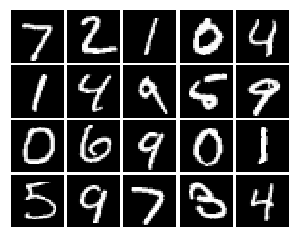

In [18]:
img=imgs[0]
imgr=torch.tensor(img.reshape(1,1,28,28))
print(imgr.shape)
imgr = imgr.to(device=device,dtype=dtype)
imgo = modelDecTest(imgr)
imgo = imgo.view(28*28).cpu().detach().numpy()
print(img.shape,imgo.shape)
show_images(np.array([imgs[i] for i in range(20)]))

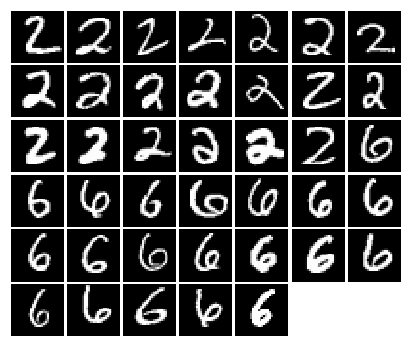

In [65]:
img_stat = [[] for i in range(params.classes_num)]
for it, (xbat,ybat) in enumerate(loader_test):
    for i in range(len(ybat)):
        x = xbat[i]
        y = ybat[i]
        img_stat[y.item()].append( x.view(img_size*imgs_size) )
#print([img_stat[0][i].view(784) for i in range(20)])
showed = [img_stat[2][i] for i in range(20)]
showed += [img_stat[6][i] for i in range(20)]
torch.stack(showed)
show_images(torch.stack(showed))

In [135]:
inter_img1 = img_stat[2][18].view(1,img_channel,img_size,img_size)
inter_img2 = img_stat[6][10].view(1,img_channel,img_size,img_size)
inter_img1 = inter_img1.to(device=device,dtype=dtype)
inter_img2 = inter_img2.to(device=device,dtype=dtype)
def show_interpolated(disent_net, inter_step = 4):
    #s_encoder is precomputed
    z_encoder = disent_net.get_z_encoder()
    decoder   = disent_net.get_decoder()
    

    s_lat1 = s_encoder(inter_img1)
    z_lat1 = z_encoder(inter_img1)
    s_lat2 = s_encoder(inter_img2)
    z_lat2 = z_encoder(inter_img2)
    
    weights = np.arange(0,1,1/(inter_step-1))
    weights = np.append(weights,1.)
    weights = torch.tensor(weights)
    weights = weights.to(device=device,dtype=dtype)
    
    print(z_lat1,z_lat2)
    
    img_lists = []
    for row_w in weights:
        for col_w in weights:
            s_latent = row_w * s_lat1 + (1-row_w)*s_lat2
            z_latent = col_w * z_lat1 + (1-col_w)*z_lat2
            latent = torch.cat((s_latent,z_latent),dim=1)
            recon  = decoder(latent)
            img_lists.append(recon.view( img_size*img_size ) )
    
    show_images(torch.stack(img_lists).detach().cpu().numpy())

In [172]:
def train_DisAdvNet(adv_net, adv_solver, disent_net, disent_solver, s_enc, z_enc, sz_dec, z_adv, epochs=1):
    """
    Train DisAdvNet on MNIST .
    
    Inputs:
    - model: the enc-classifier 
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    recon_w = params.recon_w
    adv_w = params.adv_w
    
    
    show_every = 1000
    adv_net = adv_net.to(device=device) # move the model parameters to device
    disent_net = disent_net.to(device=device) # move the model parameters to device
    iter_count = 1
    adv_disent_ratio = params.adv_disent_ratio
    
    disent_loss = 1000000.
    adv_loss = 1000000.
    
    for epoch in range(epochs):
        for it, (x,y) in enumerate(loader_train):
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            ############ train disentangle net
            if iter_count % (adv_disent_ratio+1)==0:
                
                layers.set_trainable(s_enc,False)
                layers.set_trainable(z_enc,True)
                layers.set_trainable(sz_dec,True)
                layers.set_trainable(z_adv,False)
                
                disent_solver.zero_grad()
                
                
                s_latent = s_enc(x)
                x_reconstructed = disent_net(s_latent,x)
                reconloss = F.mse_loss(x_reconstructed, x, size_average=True)
                
                scores = adv_net(x)
                advloss   = F.cross_entropy(scores, y)
                
                disent_loss = recon_w * reconloss + adv_w * advloss
                
                disent_loss.backward()
                disent_solver.step()
                
                z_enc_test = disent_net.get_decoder()


            else:
            ############# train adv net
                layers.set_trainable(s_enc,False)
                layers.set_trainable(z_enc,False)
                layers.set_trainable(sz_dec,False)
                layers.set_trainable(z_adv,True)
                
                adv_solver.zero_grad()
                
                scores = adv_net(x)
                adv_loss   = F.cross_entropy(scores, y)
                
                adv_loss.backward()
                adv_solver.step()
                

            

            if (iter_count % show_every == 0):
                print('Iter: {}, adv_loss: {:.4}, disent_loss:{:.4}'.format(iter_count, adv_loss, disent_loss))
                show_interpolated(disent_net)
                plt.show()
                print()
            iter_count += 1
            

/home/qheldiv/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Iter: 1000, adv_loss: 1.893, disent_loss:-18.74
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


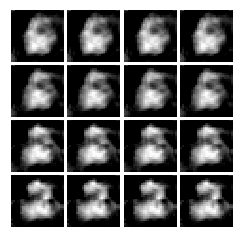


Iter: 2000, adv_loss: 1.804, disent_loss:-17.7
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


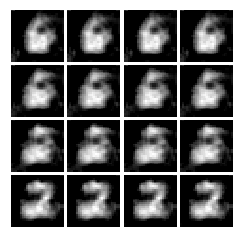


Iter: 3000, adv_loss: 1.824, disent_loss:-17.42
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


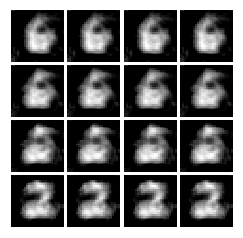


Iter: 4000, adv_loss: 1.711, disent_loss:-16.79
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


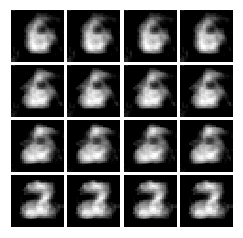


Iter: 5000, adv_loss: 1.594, disent_loss:-18.55
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


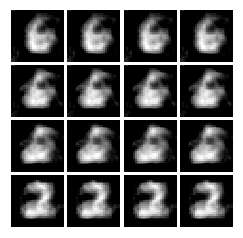


Iter: 6000, adv_loss: 1.634, disent_loss:-17.06
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


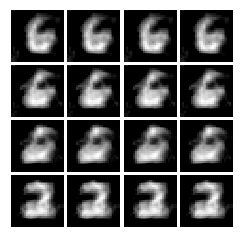


Iter: 7000, adv_loss: 1.544, disent_loss:-17.42
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


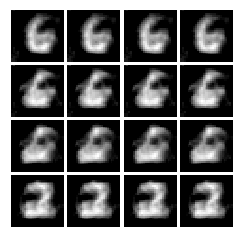


Iter: 8000, adv_loss: 1.635, disent_loss:-13.92
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


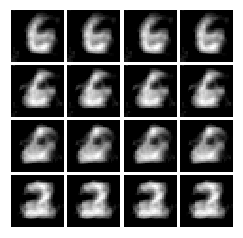


Iter: 9000, adv_loss: 1.48, disent_loss:-14.61
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


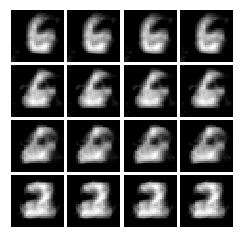


Iter: 10000, adv_loss: 1.382, disent_loss:-16.66
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


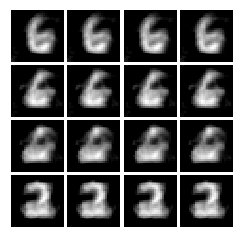


Iter: 11000, adv_loss: 1.552, disent_loss:-13.08
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


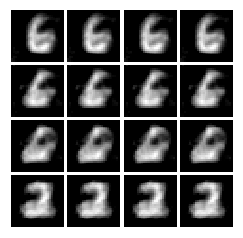


Iter: 12000, adv_loss: 1.526, disent_loss:-14.99
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


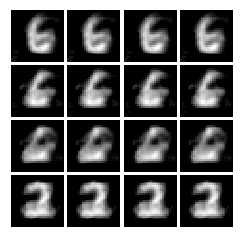


Iter: 13000, adv_loss: 1.524, disent_loss:-15.93
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


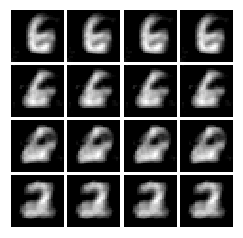


Iter: 14000, adv_loss: 1.517, disent_loss:-14.18
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


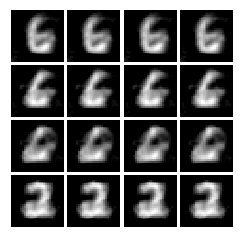


Iter: 15000, adv_loss: 1.452, disent_loss:-12.54
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


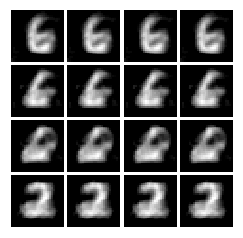


Iter: 16000, adv_loss: 1.486, disent_loss:-17.34
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


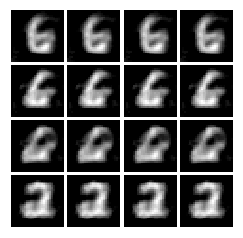


Iter: 17000, adv_loss: 1.51, disent_loss:-14.56
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


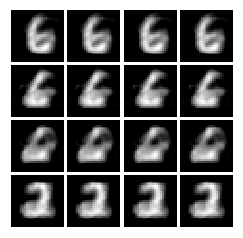


Iter: 18000, adv_loss: 1.475, disent_loss:-12.77
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


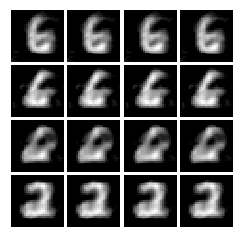


Iter: 19000, adv_loss: 1.373, disent_loss:-12.88
tensor([[ 0.6744,  0.0000,  0.3154,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0168,  0.0000,  0.0000,  0.0590,  0.0000,  0.2156,
          0.1128,  0.0000]], device='cuda:0') tensor([[ 0.4057,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0381,  0.0000]], device='cuda:0')


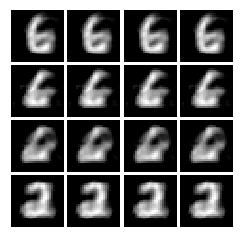

In [173]:
z_enc = Z_Encoder()
z_adv = z_AdvLayer()
sz_dec= SZ_Decoder()
adv_net = layers.AdvNet(z_enc,z_adv)
adv_solver = get_optimizer(adv_net)

disent_net = layers.DisentNet(z_enc,sz_dec)
disent_solver = get_optimizer(disent_net)

disent_net = disent_net.to(device=device)
train_DisAdvNet(adv_net, adv_solver, disent_net, disent_solver,  s_encoder, z_enc, sz_dec, z_adv,50)